In [3]:
import praw

# Reddit API credentials (replace with your own)
REDDIT_CLIENT_ID = "lMYhh7BNAjLrJQ_c7v0M5w"
REDDIT_CLIENT_SECRET = "Mq0R3nUw3FxCmfnqcLM4sIrLA1_dzg"
REDDIT_USER_AGENT = "your_user_agent"

# Initialize PRAW Reddit instance
reddit = praw.Reddit(client_id=REDDIT_CLIENT_ID,
                     client_secret=REDDIT_CLIENT_SECRET,
                     user_agent=REDDIT_USER_AGENT)

# Handel only art users

### extracting 1000 users from art only file

In [4]:
# Load the CSV file
import pandas as pd
df_art_users = pd.read_excel('only_art_users.xlsx')
df_excluded_users = pd.read_excel('posts100_tagged_with_GPT4_media_only_art.xlsx')
# Create a set of excluded users for faster lookup
excluded_users = set(df_excluded_users['User'])
# Filter df_art_users to exclude the users found in df_excluded_users
df_filtered_art_users = df_art_users[~df_art_users['User'].isin(excluded_users)]

# List of image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']
# List of image extensions

# Function to determine if a URL is an image URL
def is_image_url(url):
    return any(url.lower().endswith(ext) for ext in image_extensions)

# Apply URL filter
df_filtered_art_users['Art Post url'] = df_filtered_art_users['Art Post url'].astype(str)
filtered_df = df_filtered_art_users[~df_filtered_art_users['Art Post url'].apply(is_image_url)]

# Drop duplicates to ensure unique users
unique_posts = filtered_df.drop_duplicates(subset=['User'])

# Take top 1000 unique posts from different users
top_1000_posts = unique_posts.head(1000)



C:\Users\Yuval\AppData\Local\Temp\ipykernel_6704\1064290400.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_art_users['Art Post url'] = df_filtered_art_users['Art Post url'].astype(str)


### extracting from Reddit the posts of only_art user with is_self field

In [6]:
from collections import defaultdict
import pandas as pd
import pickle
art_forums = [
    "ArtistLounge", "ArtCrit", "art", "learnart", "drawings", "Sculpture",
    "arttutorials", "AnimeART", "PixelArt", "Pastel", "OilPainting", "Watercolor", "artlounge", "painting",
     "writing", "writers", "sciwrite", "phd", "freelanceWriters", "composer", "composition"
]
only_art_posts_no_media = defaultdict(list)
users = top_1000_posts['User'].unique()

for username in users:    
    # Search for posts by the user in art-related subreddits
    target_art_subreddits_str = '+'.join(art_forums)  # Multi-subreddit search query
    search_query = f"author:{username}"
    
    # Search the subreddit
    try:
        for post in reddit.subreddit(target_art_subreddits_str).search(search_query, limit=100):  # Adjust limit as needed            
            only_art_posts_no_media[username].append({
                'title': post.title,
                'description': post.selftext,
                'author': str(post.author),
                'post_id': post.id,
                'subreddit': str(post.subreddit),
                'score': post.score,
                'comments_count': post.num_comments,
                'post_url': post.url,
                'created_utc': post.created_utc,
                'flair': post.link_flair_text,
                'nsfw': post.over_18,
                'stickied': post.stickied,
                'edited': post.edited,
                'awards': post.total_awards_received,
                'is_video': post.is_video,
                'is_self': post.is_self,
                'media': post.media,
                'domain': post.domain,
                'post_hint': getattr(post, 'post_hint', None),  # Some posts may not have this attribute
                'media_metadata': getattr(post, 'media_metadata', None)  # Include this if available
            })

    except Exception as e:
        print(f"Error fetching posts for user {username}: {e}")


# Convert the dictionary to a DataFrame
data = []
for username, posts in only_art_posts_no_media.items():
    for post in posts:
        post['User'] = username  # Add username to the post dictionary for identification
        data.append(post)

df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
df.to_excel('only_art_posts_no_media.xlsx', index=False)


Error fetching posts for user multiverse-wanderer: received 429 HTTP response
Error fetching posts for user Mooseylips: received 429 HTTP response
Error fetching posts for user SwedishMeatballsYum: received 429 HTTP response
Error fetching posts for user c_side_art: received 429 HTTP response
Error fetching posts for user LifeofMuck: received 429 HTTP response
Error fetching posts for user Papercandy22: received 429 HTTP response
Error fetching posts for user InTheHeat0fLisbon: received 429 HTTP response
Error fetching posts for user Erik912: received 429 HTTP response
Error fetching posts for user TheCharlienator: received 429 HTTP response
Error fetching posts for user Shot_Method: received 429 HTTP response
Error fetching posts for user chiseal: received 429 HTTP response
Error fetching posts for user seehowitsfaded: received 429 HTTP response


c:\Users\Yuval\anaconda3\Lib\site-packages\xlsxwriter\worksheet.py:1251: UserWarning: Ignoring URL 'https://www.riotgames.com/en/work-with-us/job/5273291/senior-composer-creative-department-music-services-los-angeles-usa

**Responsibilities:**


*%20Collaborate%20with%20Esports%20broadcast%20production%20to%20create%20and%20adapt%20new%20and%20existing%20music%20for%20worldwide%20broadcast%20and%20live%20events%20that%20enhances%20the%20goals%20of%20the%20project.


*%20Create%20music%20for%20linear%20content%20like%20trailers%20and%20other%20publishing%20materials.


*%20Collaborate%20with%20Esports,%20Entertainment,%20and%20external%20partners%20to%20determine%20music%20vision,%20goals,%20and%20objectives%20that%20inform%20and%20support%20the%20product/teams%20vision.


*%20Work%20with%20product%20leadership%20to%20determine%20and%20manage%20milestones,%20schedule,%20vendors,%20priorities,%20and%20work%20output%20for%20an%20entire%20product.


*%20Provide%20on-site%20consultation%20f

### taking posts only since 2018

In [105]:
import pandas as pd

# Load the Excel file
df = pd.read_excel('only_art_posts_no_media.xlsx')

# Convert 'created_utc' from UNIX timestamp to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

# Filter the DataFrame to include only entries from 2019 onwards
df = df[df['created_utc'].dt.year > 2018]

# Save the filtered DataFrame to a new Excel file
df.to_excel('only_art_posts_no_media_2018.xlsx', index=False)


### count the amount of posts with is_false=false for each user

In [109]:
import pandas as pd

# Load the Excel file
df = pd.read_excel('only_art_posts_no_media_2018.xlsx')

# Calculate the count of 'is_self' == False for each user
count_df = df[df['is_self'] == False].groupby('User').size().reset_index(name='use_media_amount')

# Merge this count back into the original DataFrame
# This will add the 'use_media_amount' column to all entries of the same user
result_df = df.merge(count_df, on='User', how='left')

# Fill NaN values with 0 where there were no 'is_self' == False posts
result_df['use_media_amount'].fillna(0, inplace=True)
# If the user uploaded post with image he is creative user
result_df['is_creative'] = result_df['use_media_amount'] > 0
unique_user_count = result_df['User'].nunique()

# Save the updated DataFrame to a new Excel file
result_df.to_excel('only_art_posts_no_media_amount.xlsx', index=False)
print("Number of unique users:", unique_user_count)


Number of unique users: 844


### extract posts with not creative keywords

In [110]:
import pandas as pd
# Define a list of not creative keywords
not_creative_keywords = [
    "Burnout", "blocked", "creative block",
"Struggling", "difficulty", "can't",
"Lost", "losing", "lack",
"Stuck", "stagnant", "uninspired",
"Frustrated", "frustrating",
"Empty", "hollow",
"Overwhelmed", "discouraged", "demotivated",
"Regain", "restart",
"no Motivation", "no inspiration",
"Start again", "back to", "return to",
"Sad", "frustrated", "bored",
"Not fun", "no joy", "tired",
 "unsure", "defeated",
"Feel like giving up",
"How can I", "Why can’t I", "What do I do if",
"Help with", "Struggling to", "Can’t seem to",
"Lost motivation for",
"Can't seem to create anymore",
"How to start making art again",
"Struggling with creativity",
"Why do I feel stuck in"
]
# Load the Excel file
df = pd.read_excel('only_art_posts_no_media_amount.xlsx')

# Filter the DataFrame to include only rows where both 'title' and 'description' are not empty
df = df[df['title'].notna() & df['description'].notna()]

# Function to check for not_creative_keywords in both 'title' and 'description' columns
def contains_keywords(row):
    title = str(row['title']) if pd.notna(row['title']) else ''
    description = str(row['description']) if pd.notna(row['description']) else ''
    combined_text = title + " " + description
    return any(keyword.lower() in combined_text.lower() for keyword in not_creative_keywords)

# Apply the function to check for not_creative_keywords in sport_and_art DataFrame
df['contains_not_creative'] = df.apply(contains_keywords, axis=1)

# Save the updated DataFrame to a new Excel file
df.to_excel('only_art_posts_with_not_creative_keywords.xlsx', index=False)


# Handel sport and art users

### extracting unique users of sport and art users that we didn't use

In [25]:
import pandas as pd
import numpy as np

# Load the Excel files into DataFrames
df_all_posts = pd.read_excel('user_posts_art_and_sport_only_sport_filter_all_posts.xlsx')
df_exclude_users = pd.read_excel('posts100_tagged_with_GPT4_media_art_and_sport.xlsx')

# Assuming the user column in df_exclude_users is named 'User' as per your previous descriptions
# Get unique users to exclude
users_to_exclude = df_exclude_users['User'].unique()
users_to_exclude = np.append(users_to_exclude, 'AutoModerator')

# Filter out the rows where User is in the users_to_exclude list
filtered_df = df_all_posts[~df_all_posts['User'].isin(users_to_exclude)]

# Save the filtered data to a new Excel file
filtered_df.to_excel('sport_and_art_posts_not_tagged.xlsx', index=False)


### counting the amount of media for users we didnt use from art and sport

In [75]:
from collections import defaultdict
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')

art_forums = [
    "ArtistLounge", "ArtCrit", "art", "learnart", "drawings", "Sculpture",
    "arttutorials", "AnimeART", "PixelArt", "Pastel", "OilPainting", "Watercolor", "artlounge", "painting",
     "writing", "writers", "sciwrite", "phd", "freelanceWriters", "composer", "composition"
]
df = pd.read_excel('sport_and_art_posts_not_tagged.xlsx')

users = df['User'].unique()
print("Number of unique users:", len(users))
sport_and_art_posts_no_media = defaultdict(list)

for username in users:    
    # Search for posts by the user in art-related subreddits
    target_art_subreddits_str = '+'.join(art_forums)  # Multi-subreddit search query
    search_query = f"author:{username}"
    
    # Search the subreddit
    try:
        for post in reddit.subreddit(target_art_subreddits_str).search(search_query, limit=100):  # Adjust limit as needed            
            sport_and_art_posts_no_media[username].append({
                'title': post.title,
                'description': post.selftext,
                'author': str(post.author),
                'post_id': post.id,
                'subreddit': str(post.subreddit),
                'score': post.score,
                'comments_count': post.num_comments,
                'post_url': post.url,
                'created_utc': post.created_utc,
                'flair': post.link_flair_text,
                'nsfw': post.over_18,
                'stickied': post.stickied,
                'edited': post.edited,
                'awards': post.total_awards_received,
                'is_video': post.is_video,
                'is_self': post.is_self,
                'media': post.media,
                'domain': post.domain,
                'post_hint': getattr(post, 'post_hint', None),  # Some posts may not have this attribute
                'media_metadata': getattr(post, 'media_metadata', None)  # Include this if available
            })

    except Exception as e:
        print(f"Error fetching posts for user {username}: {e}")


# Convert the dictionary to a DataFrame
data = []
for username, posts in sport_and_art_posts_no_media.items():
    for post in posts:
        post['User'] = username  # Add username to the post dictionary for identification
        data.append(post)

df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
df.to_excel('sport_and_Art_not_used.xlsx', index=False)


Number of unique users: 28


### taking posts only since 2018

In [76]:
import pandas as pd

# Load the Excel file
df = pd.read_excel('sport_and_Art_not_used.xlsx')

# Convert 'created_utc' from UNIX timestamp to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')

# Filter the DataFrame to include only entries from 2019 onwards
df = df[df['created_utc'].dt.year > 2018]
unique_user_count = df['User'].nunique()
# Save the filtered DataFrame to a new Excel file
df.to_excel('sport_and_Art_not_used_2018.xlsx', index=False)
print("Number of unique users:", unique_user_count)


Number of unique users: 24


### count the amount of posts without media, is_self=false

In [97]:
import pandas as pd

# Load the Excel file
df = pd.read_excel('sport_and_Art_not_used_2018.xlsx')

# Calculate the count of 'is_self' == False for each user
count_df = df[df['is_self'] == False].groupby('User').size().reset_index(name='use_media_amount')

# Merge this count back into the original DataFrame
# This will add the 'use_media_amount' column to all entries of the same user
result_df = df.merge(count_df, on='User', how='left')

# Fill NaN values with 0 where there were no 'is_self' == False posts
result_df['use_media_amount'].fillna(0, inplace=True)

# If the user uploaded post with image he is creative user
result_df['is_creative'] = result_df['use_media_amount'] > 0

# Save the updated DataFrame to a new Excel file
result_df.to_excel('sport_and_Art_not_used_no_media_amount.xlsx', index=False)


### boolean column saying if the post have a not creative keyword

In [98]:
# Load the Excel files
df = pd.read_excel('sport_and_Art_not_used_no_media_amount.xlsx')

# Function to check for not_creative_keywords in both 'title' and 'description' columns
def contains_keywords(row):
    title = str(row['title']) if pd.notna(row['title']) else ''
    description = str(row['description']) if pd.notna(row['description']) else ''
    combined_text = title + " " + description
    return any(keyword.lower() in combined_text.lower() for keyword in not_creative_keywords)

# Apply the function to check for not_creative_keywords in sport_and_art DataFrame
df['contains_not_creative'] = df.apply(contains_keywords, axis=1)

# Save the updated DataFrame to a new Excel file
df.to_excel('sport_and_Art_not_used_no_media_amount_is_not_creative.xlsx', index=False)

# Feature Calculation for the 100 tagged posts

### combine sheets and add is_creative column

In [112]:
import pandas as pd

# Load the Excel file
file_path = 'posts100_tagged_with_GPT4_with_ImagePostsCount_categories.xlsx'
xls = pd.ExcelFile(file_path)

# Read sheets
df1 = pd.read_excel(xls, 'sport and art users posts')  
df2 = pd.read_excel(xls, 'only art users posts')  

# Define a function to determine creativity
def check_creativity(grade):
    if grade == "Rather productive":
        return True
    else:
        return False

# Apply the function to create 'is_creative' column
df1['is_creative'] = df1['GPT Grade1'].apply(check_creativity)
df2['is_creative'] = df2['GPT Grade1'].apply(check_creativity)

# Combine the dataframes if necessary
combined_df = pd.concat([df1, df2], ignore_index=True)

# Save the combined dataframe to a new Excel file if needed
combined_df.to_excel('combined_with_is_creative.xlsx', index=False)


In [119]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textstat import textstat
import emoji
def demojize_text(text):
    emoji_counter = []
    for word in text:
        if len(emoji.distinct_emoji_list(word)) > 0:
            emoji_counter.append(emoji.distinct_emoji_list(word)[0])
    return emoji_counter
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Load data
df = pd.read_excel('combined_with_is_creative.xlsx')

# Convert 'created_utc' to datetime
# df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['Art Created UTC'] = pd.to_datetime(df['Art Created UTC'], unit='s')


# Combine 'title' and 'description' into a single 'text' column
df['text'] = df['Art Title'].astype(str) + " " + df['Art Description'].astype(str)

# Assume 'is_creative' is a column in your DataFrame. Convert it to boolean if it's not already
df['is_creative'] = df['is_creative'].astype(bool)

# Define the feature calculation function
def calculate_features(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    char_count = len(text)
    word_count = len(words)
    sentence_count = len(sentences)
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    avg_sentence_length = sum(len(sentence) for sentence in sentences) / sentence_count if sentence_count > 0 else 0
    verbs_count = sum(1 for word, pos in nltk.pos_tag(words) if pos.startswith('VB'))
    stopwords_count = sum(1 for word in words if word.lower() in stopwords.words('english'))
    all_caps_count = sum(1 for word in words if word.isupper())
    punctuation_counts = {f'punctuation_{p}': text.count(p) for p in ".?!"}
    emoji_count = len(demojize_text(text))
    readability_score = textstat.flesch_reading_ease(text)
    compound_score = SentimentIntensityAnalyzer().polarity_scores(text)['compound']

    return {
        'word_count': word_count,
        'char_count': char_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'verbs_count': verbs_count,
        'stopwords_count': stopwords_count,
        'all_caps_count': all_caps_count,
        **punctuation_counts,
        'emoji_count': emoji_count,
        'readability_score': readability_score,
        'compound_score': compound_score
    }

# Apply function to create features
feature_columns = df['text'].apply(lambda x: pd.Series(calculate_features(x)))
df = pd.concat([df, feature_columns], axis=1)

# Convert subreddit categories to numeric
df['subreddit_numeric'] = pd.Categorical(df['Art Subreddit']).codes
df['post_count'] = df.groupby('User').size()

# Group by user and aggregate data
grouped = df.groupby('User').agg({
    **{col: 'mean' for col in df.columns if col.startswith('word_count') or col.startswith('char_count') or col.startswith('sentence_count') or col.startswith('avg_') or col.startswith('verbs_count') or col.startswith('stopwords_count') or col.startswith('all_caps_count') or col.startswith('punctuation_') or col.startswith('emoji_count') or col.startswith('readability_score') or col.startswith('compound_score')},
    'Art Score': 'mean',
    'subreddit_numeric': 'mean',
    'post_count': 'size',
    'is_creative': 'any'  # Check if any post is marked as creative
})

# Save to Excel
grouped.to_excel('100_users_metadata.xlsx')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yuval\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yuval\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yuval\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Yuval\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Decision Tree Classification

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.89      0.94      0.91        17

    accuracy                           0.85        20
   macro avg       0.69      0.64      0.66        20
weighted avg       0.83      0.85      0.84        20

Confusion Matrix:
[[ 1  2]
 [ 1 16]]


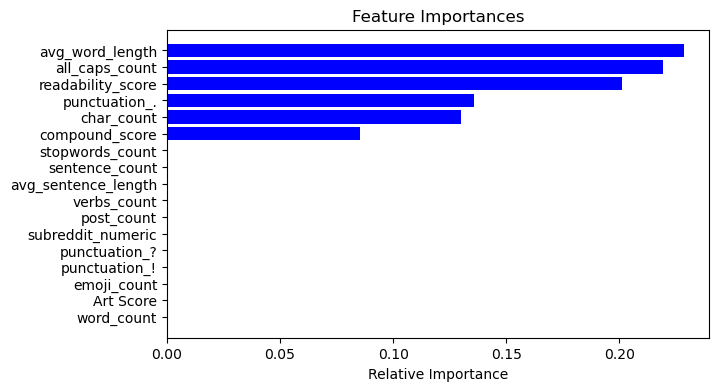

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load your data
df = pd.read_excel('100_users_metadata.xlsx')

# Separate the features and the target variable
X = df.drop(columns=['User', 'is_creative'])  # Drop 'User' as it's an identifier and 'is_creative' as it's the target
y = df['is_creative'].astype(int)  # Ensure the target is integer type for scikit-learn

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 20% data as test set

# Create a decision tree classifier object
clf = DecisionTreeClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Print the classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot feature importances
features = X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(7, 4))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
